### 前言

《【Python金融量化】上市公司知多少？》一文对A股上市公司的基本概况做了一个简要的可视化分析，延续那篇文章，本文将继续介绍基于tushare获取数据，使用python进行数据清洗、特征分组和排序，一步步筛选出符合设定条件的股票组合。

#### 指导逻辑

选股涉及两个方面，一是公司分析，包括财务状况、发展潜力和成长性等，这方面是俗称的基本面分析，可以参考的资料已经汗牛充栋；二是股票分析。
股票分析主要回答三个问题：  
（1）如何判断一只股票有投资价值？  
（2）如何从股票池中选出符合自己认为有价值的股票？  
（3）选出合适的股票后如何构建投资组合并动态调整？  

总体思维：多层次多角度分析  
多角度保证在市场大方向上看对的正确率尽可能增加，多层次可以和多角度相互验证，获取超额收益。  
通过自上而下的分析框架确定投资方向，选择符合投资方向的最优标的。  

操作思路：根据股票基本面指标进行排序，通过设置参数和过滤值筛选投资标的，具体指标包括市盈率、市净率、流通股本、总市值、每股公积金、每股收益、收入同比、利润同比、毛利率、净利润率等。


#### 敬告
本文不详细展开对股市投资逻辑和选股策略的理解，主要介绍基于python如何一步步筛选出符合自己设定要求的股票组合，希望能起到抛砖引玉的作用。
文中提及股票和选股思路不构成投资建议或交易策略。交易有风险，入市需谨慎！

### 前期准备
#### 导入需要的包

In [1]:
#先引入后面可能用到的包（package）
import pandas as pd  
import numpy as np
from scipy import stats
import tushare as ts 
import matplotlib.pyplot as plt
%matplotlib inline   

#正常显示画图时出现的中文和负号
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

#### 数据获取
基于tushare开源包获取A股基本面和交易数据。

In [2]:
#基本面数据
basics_data=ts.get_stock_basics()
#时间默认为当前交易日的上一个交易日
#交易数据
trade_data=ts.get_today_all()
#时间默认为当前交易日的上一个交易日

[Getting data:]############################################################

In [3]:
#了解数据1
basics_data.head(3)

,name,industry,area,pe,outstanding,totals,totalAssets,liquidAssets,fixedAssets,reserved,...,bvps,pb,timeToMarket,undp,perundp,rev,profit,gpr,npr,holders
code,,,,,,,,,,,,,,,,,,,,,
600035,楚天高速,路桥,湖北,11.49,15.27,17.28,1076654.25,167482.17,58697.19,135630.63,...,3.63,1.20,20040310,225072.09,1.30,20.81,1.61,39.71,22.33,68217.0
600226,瀚叶股份,农药化肥,浙江,50.51,19.93,31.39,532053.19,178304.38,43936.78,32427.44,...,1.41,3.25,19991116,74645.61,0.24,-28.02,-3.02,43.55,29.95,33932.0
002011,盾安环境,工程机械,浙江,107.07,8.41,9.17,1188420.38,529358.88,175676.13,211654.70,...,2.43,2.65,20040705,123072.81,1.34,15.06,-28.73,14.74,0.61,71700.0


各变量名称含义：code,代码；
name,名称；
industry,细分行业；
area,地区；
pe,市盈率；
outstanding,流通股本；
totals,总股本(万)；
totalAssets,总资产(万)；
liquidAssets,流动资产；
fixedAssets,固定资产；
reserved,公积金；
reservedPerShare,每股公积金；
eps,每股收益；
bvps,每股净资；
pb,市净率；
timeToMarket,上市日期；
undp 未分配利润；
perundp 每股未分配；
rev 收入同比（%）；
profit 利润同比（%）；
gpr 毛利率（%）；
npr 净利润率（%）；
holders_num 股东人数

In [4]:
#了解数据2
trade_data.head(3)

,code,name,changepercent,trade,open,high,low,settlement,volume,turnoverratio,amount,per,pb,mktcap,nmc
0,603999,读者传媒,1.070,6.61,6.52,6.80,6.46,6.54,17945139.0,3.11548,119326787.0,50.458,2.242,380736.00000,380736.00000
1,603998,方盛制药,-3.017,6.43,6.62,6.65,6.35,6.63,6847435.0,1.61042,44764170.0,45.929,2.646,280748.40896,273401.49096
2,603997,继峰股份,-2.343,9.17,9.39,9.48,9.15,9.39,3544981.0,0.56270,33055482.0,19.935,3.227,586341.90440,577710.00000


各变量含义：代码，名称，涨跌幅，现价，开盘价，最高价，最低价，昨日收盘价，成交量，换手率，成交额，市盈率，市净率，总市值，流通市值

#### 数据清洗
数据清洗过程大致包含：选择子集、列名重命名、缺失数据处理、数据类型转换、数据排序、异常值处理等。

In [5]:
#选择子集和为变量重命名
#基本面数据包含的变量22列，交易数据15列，只保留后面分析要用到的几个指标
#保留code、name、流通股本、市盈率、市净率、每股收益
#每股公积、收入同比、利润同比、毛利率、净利率
#流通市值、收盘价、总市值

#基本面数据清洗
col=['name','outstanding','pe','pb','esp',
     'reservedPerShare','rev','profit','gpr','npr']
newcol=['简称','流通股','市盈率','市净率','每股收益','每股公积',
        '收入同比','利润同比','毛利率','净利率']
d=dict(zip(col,newcol))
b_data=basics_data.loc[:,col]
b_data.rename(columns=d,inplace=True)
b_data.head()

,简称,流通股,市盈率,市净率,每股收益,每股公积,收入同比,利润同比,毛利率,净利率
code,,,,,,,,,,
600035,楚天高速,15.27,11.49,1.20,0.284,0.78,20.81,1.61,39.71,22.33
600226,瀚叶股份,19.93,50.51,3.25,0.068,0.10,-28.02,-3.02,43.55,29.95
002011,盾安环境,8.41,107.07,2.65,0.045,2.31,15.06,-28.73,14.74,0.61
000839,中信国安,39.19,3655.40,3.75,0.001,0.39,-7.12,-97.80,14.93,0.18
000609,中迪投资,2.92,0.00,1.29,-0.021,0.16,-91.88,-105.16,21.97,-32.38


In [6]:
#交易数据清洗
##当前股价,如果停牌则设置当前价格为上一个交易日股价 
trade_data['trade'] = trade_data.apply(lambda x:x.settlement if x.trade==0 else x.trade, axis=1) 
#选取股票代码,名称,当前价格,总市值,流通市值 
t_data = trade_data.loc[:,['code', 'trade', 'mktcap', 'nmc','volume','turnoverratio']] 
#设置行情数据code为index列 
t_data = t_data.set_index('code') 
t_data.rename(columns={'trade':'收盘价','mktcap':'总市值','nmc':'流通市值',
                       'volume':'成交量','turnoverratio':'换手率'},inplace=True)
#将总市值和流通值换成亿元单位
t_data['总市值'] = t_data['总市值'] / 10000 
t_data['流通市值'] = t_data['流通市值'] / 10000 
t_data.head(3)

,收盘价,总市值,流通市值,成交量,换手率
code,,,,,
603999,6.61,38.073600,38.073600,17945139.0,3.11548
603998,6.43,28.074841,27.340149,6847435.0,1.61042
603997,9.17,58.634190,57.771000,3544981.0,0.56270


In [7]:
#合并两个数据表 
data = b_data.merge(t_data, left_index=True, right_index=True) 
data.head(3)

,简称,流通股,市盈率,市净率,每股收益,每股公积,收入同比,利润同比,毛利率,净利率,收盘价,总市值,流通市值,成交量,换手率
code,,,,,,,,,,,,,,,
000001,平安银行,171.70,8.56,0.96,1.390,3.29,10.33,7.02,0.00,21.26,12.37,2123.979886,2123.959526,126942716.0,0.73932
000002,万 科Ａ,97.15,16.46,2.19,1.267,0.80,50.32,26.09,34.76,7.94,27.81,3069.988171,2701.788789,79146059.0,0.81466
000004,国农科技,0.83,0.00,12.95,-0.031,0.01,260.83,52.31,82.43,-1.01,19.60,16.459430,16.270584,1690148.0,2.03600


In [8]:
#数据描述性统计
data.describe().round(2)

,流通股,市盈率,市净率,每股收益,每股公积,收入同比,利润同比,毛利率,净利率,收盘价,总市值,流通市值,成交量,换手率
count,3656.00,3656.00,3656.00,3656.00,3656.00,3656.00,3656.00,3656.00,3656.00,3656.00,3656.00,3656.00,3.656000e+03,3656.00
mean,13.67,86.56,5.25,0.33,1.93,24.03,22.40,29.04,-3.39,14.56,167.79,121.52,2.948396e+07,4.99
std,84.44,331.62,57.93,0.59,1.76,142.49,568.20,23.60,404.51,19.19,730.23,527.76,5.345324e+07,5.34
min,0.10,0.00,-404.75,-4.56,-1.18,-100.14,-6472.94,-779.78,-17764.19,0.77,2.65,2.65,0.000000e+00,0.00
25%,1.93,16.68,1.69,0.07,0.71,0.00,-21.91,16.43,2.79,6.08,31.89,21.73,5.732009e+06,1.69
50%,4.67,30.61,2.57,0.22,1.50,11.96,9.73,26.24,7.66,9.90,53.50,39.88,1.384554e+07,3.25
75%,9.93,57.29,3.95,0.46,2.60,27.62,44.24,39.04,14.33,17.04,111.11,82.31,3.257228e+07,6.28
max,2940.55,8350.34,2458.03,19.69,15.74,5053.27,18509.93,99.85,1332.62,754.00,19887.47,15044.36,1.441156e+09,59.65


### 数据探索与分析


#### 大盘股vs小盘股
小盘股是相对大盘股而言的，而中盘股是介于大盘股和小盘股之间。市场上传统划分方法是根据流通股本的大小：一般流通股本超过10亿股为大盘股，流通股本小于5亿股为小盘股，流通股本5亿-10亿的属于中盘股。如果以市值衡量，总市值大于1000亿的属于超大盘股，总市值大于500亿以上的属于大盘股，总市值小于200亿的属于小盘股，处于200亿-500亿总市值的股票，属于中盘股。
  
实际上关于大盘股和中小盘股的划分并没有统一的标准。大盘股和小盘股的区别并不是固定的，随着上市公司的增多，以及A股市场总市值的不断变化，大小盘的划分标准也应该是动态变化的。

为什么要划分大盘股和中小盘股呢？换句话，大盘股和小盘股有什么明显的区别吗？一般而言，相同业绩的个股，小盘股的市盈率比中盘股高，中盘股要比大盘股高。特别在市场疲软时，小盘股机会较多。在牛市时大盘股和中盘股较适合大资金的进出，因此盘子大的个股比较看好。由于流通盘大，对指数影响大，往往成为市场调控指数的工具。投资者选择个股，一般熊市应选小盘股和中小盘股，牛市应选大盘股和中大盘股。  

In [9]:
#生成频率表
#利用cut函数，将连续变量转为分类变量
def df_cut(data, cut, labels=None): 
    min_num = data.min() 
    max_num = data.max() 
    b = [min_num] + cut + [max_num]
    if not labels: 
        labels = range(len(cut)+1)
    else: 
         labels=[labels[i] for i in range(len(cut)+1)] 
    Bin = pd.cut(data,bins=b,
         labels=labels,include_lowest=True)    
    return Bin 

#data['流通股'].quantile(0.9)
#由于流通股的90分位数点为20亿左右，中位数为5亿左右
#这里将流通股本小于5亿的划分为小盘股，大于20亿的为大盘股
#当然也可以使用总市值来划分，或者使用流通股本和收盘价中位数来确定

cut = [5,20] 
labels=['小盘股', '中盘股','大盘股'] 
#调用函数df_cut,增加新列
data_new=data.loc[:,['简称','收盘价','流通股','市盈率','每股收益','净利率','收入同比','利润同比']]
data_new['股票类型'] = df_cut(data['流通股'], cut, labels) 
#查看标签列，取值范围前面加上了序号，是便于后面生成表格时按顺序排列
data_new.head()

,简称,收盘价,流通股,市盈率,每股收益,净利率,收入同比,利润同比,股票类型
code,,,,,,,,,
000001,平安银行,12.37,171.70,8.56,1.390,21.26,10.33,7.02,大盘股
000002,万 科Ａ,27.81,97.15,16.46,1.267,7.94,50.32,26.09,大盘股
000004,国农科技,19.60,0.83,0.00,-0.031,-1.01,260.83,52.31,小盘股
000005,世纪星源,3.81,10.58,463.08,0.006,1.71,21.89,140.29,中盘股
000006,深振业Ａ,6.22,13.48,12.51,0.373,31.57,-31.28,48.39,中盘股


In [10]:
data_new.groupby('股票类型')[['市盈率','收盘价','每股收益']].describe(percentiles=[0.5]).round(2)

市盈率                                         收盘价                      \
       count   mean     std  min    50%      max   count   mean    std   min   
股票类型                                                                           
小盘股   1890.0  94.07  324.65  0.0  37.28  5628.63  1890.0  18.96  17.34  0.77   
中盘股   1385.0  82.01  342.00  0.0  25.17  8350.34  1385.0  10.10  21.95  1.27   
大盘股    381.0  65.86  327.22  0.0  17.29  3655.40   381.0   8.99   9.71  0.87   

                       每股收益                                 
        50%     max   count  mean   std   min   50%    max  
股票类型                                                        
小盘股   14.03  271.92  1890.0  0.36  0.51 -4.56  0.25   7.09  
中盘股    6.75  754.00  1385.0  0.27  0.67 -2.98  0.17  19.69  
大盘股    6.18   76.50   381.0  0.42  0.61 -1.73  0.25   4.69

从分组描述性统计上看，小盘股市盈率平均值明显高于大盘股，高达75倍；小盘股股价平均值为15.47元，是大盘股股价平均值的两倍左右。可见二者在估值上还是存在较大差异的。如果要从更严谨的角度去判别，可以根据分组统计结果对数据进行统计上的T检验，这里不再展开分析。

In [11]:
data_new.groupby('股票类型')[['净利率','利润同比','收入同比']].describe(percentiles=[]).round(2)

净利率                                            利润同比                 \
       count   mean     std       min   50%      max   count   mean     std   
股票类型                                                                          
小盘股   1890.0  -0.86  349.23 -14735.66  8.36  1332.62  1890.0  11.51  499.02   
中盘股   1385.0 -11.17  514.96 -17764.19  6.31   266.53  1385.0  37.22  706.56   
大盘股    381.0  12.38   34.44   -140.74  7.98   461.50   381.0  22.55  218.73   

                                  收入同比                                         
          min    50%       max   count   mean     std     min    50%      max  
股票类型                                                                           
小盘股  -6472.94   8.01   7123.57  1890.0  24.98  108.66 -100.14  12.68  2920.96  
中盘股  -5737.62  11.61  18509.93  1385.0  24.79  190.12  -99.77  11.78  5053.27  
大盘股  -1324.33   8.47   3131.50   381.0  16.54   69.94  -93.50  10.57   780.28

从净利率上看，大盘股明显占优，平均12.64%的净利率，而中盘股是-11.56%，看来今年营商环境恶劣，承压比较大的是中盘股类型的上市公司。大盘股往往是传统行业，例如银行、房地产、钢铁、石油石化、煤炭、有色金属等，还是最赚钱的主啊。此外，可以发现一个有趣的现象，中小盘股内部两级分化很严重，如小盘股净利率最高的达1332.62%，最差的为-14735.66%，意味着有的中小盘股逆势赚钱，有的可能已经亏到“底裤”都没了。收入同比上，是小盘股占优，一般而言，中小盘股的成长性要比大盘股好，但是波动性也明显更大。关于规模与股票估值可以深入挖掘的东西还很多，特别是可以使用分位数回归，研究不同规模股票之间的收益率差异。

#### 毛利率
计算公式：毛利率=（销售收入－销售成本）/销售收入×100%。毛利率对于判断公司盈利能力而言是很重要的指标，高毛利可以反映出公司的竞争优势。但是不同行业间毛利差异是很大的，一般要在同一个行业里比较。一般而言，毛利率越高反映公司盈利能力越强，公司投资价值越高。但是，要注意不能单纯使用该指标来选股，因为高毛利背后也有坑，如把成本算到费用去了（如某些软件公司），毛利率自然就高，一定要结合净利率来看。

In [132]:
#根据毛利率高低排序，选出毛利率最高的十只股票。

In [12]:
data.sort_values('毛利率',ascending=False)[:10]

,简称,流通股,市盈率,市净率,每股收益,每股公积,收入同比,利润同比,毛利率,净利率,收盘价,总市值,流通市值,成交量,换手率
code,,,,,,,,,,,,,,,
000416,民生控股,5.32,134.12,3.25,0.030,0.05,937.76,-41.42,99.85,26.60,5.29,28.136002,28.123814,16924729.0,3.18349
600570,恒生电子,6.18,113.23,17.10,0.584,0.67,18.93,24.42,97.00,18.37,88.13,544.471705,544.471705,36793937.0,5.95559
300624,万兴科技,0.49,57.25,8.73,0.930,3.64,13.62,37.80,95.69,18.89,68.10,55.257702,33.042113,4288630.0,8.83889
300558,贝达药业,1.70,93.43,8.51,0.368,1.52,20.74,-27.37,95.47,15.93,45.90,184.059000,77.893380,4385091.0,2.58399
603039,泛微网络,0.40,118.81,14.18,0.600,2.64,38.82,21.34,95.32,9.51,91.50,93.795819,36.509232,586116.0,1.46893
603590,康辰药业,0.40,28.09,2.44,1.260,6.14,0.00,0.00,94.98,22.55,36.74,58.784000,14.696000,2525220.0,6.31305
300295,三六五网,1.78,27.83,2.65,0.434,1.47,2.17,6.04,94.90,23.23,16.09,31.053056,28.717527,11902396.0,6.66873
002410,广联达,8.86,83.01,10.15,0.260,0.37,26.15,2.10,94.75,16.46,28.76,323.996338,254.932303,19197041.0,2.16570
600258,首旅酒店,6.25,16.71,2.21,0.819,4.84,0.90,45.62,94.56,12.59,18.24,178.549773,113.928744,6990129.0,1.11912


以上十只股票的毛利率都超过90%，但是净利率并不高！第十只股票山东金泰出现了亮点：毛利率94.36%，但是净利率却是-177.2%，利润同比-58.91%，可以说是very interesting了，感兴趣的朋友可以深入挖掘下，这年头陷阱太多，单一角度看问题，很容易掉坑里（是我太单纯，还是世界太复杂！）。从山东金泰近两年走势来看，相对大盘指数跌了很多，可见市场还是相对“理性”的。

In [13]:
#构建股票数据获取和可视化函数
def get_data_plot(code,startdate,name):
    sh=ts.get_k_data('sh',start=startdate)
    sh.index=pd.to_datetime(sh.date)
    df=ts.get_k_data(code,start=startdate)
    df.index=pd.to_datetime(df.date)
    fig = plt.figure(figsize=(12,6))  
    ax1 = fig.add_subplot(111)  
    ax1.plot(df['close'],color='r',label=name)
    ax1.legend(loc=2)
    ax2=ax1.twinx()
    ax2.plot(sh['close'],color='k',label='上证指数')
    plt.title(name+'vs上证指数近几年走势',fontsize=15)
    ax2.legend(loc=1)
    plt.show()

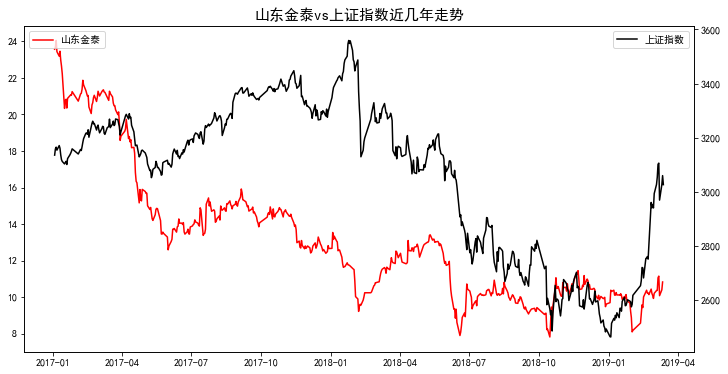

In [14]:
get_data_plot('600385','2017-01-01','山东金泰')

In [15]:
#再来看看毛利率最低的十只股票
data.sort_values('毛利率',ascending=True)[:10]

,简称,流通股,市盈率,市净率,每股收益,每股公积,收入同比,利润同比,毛利率,净利率,收盘价,总市值,流通市值,成交量,换手率
code,,,,,,,,,,,,,,,
600890,中房股份,5.79,0.0,17.59,-0.057,0.04,-66.94,-29.33,-779.78,-7075.61,7.92,45.872238,45.872238,6811823.0,1.17608
000503,国新健康,8.99,0.0,14.07,-0.126,0.00,-58.42,26.66,-112.44,-242.95,20.44,183.719258,183.710618,31753016.0,3.53290
600896,*ST海投,5.77,92.8,2.63,0.042,2.10,20.32,126.11,-85.14,90.43,5.17,44.932422,29.837532,3927031.0,0.68044
600896,*ST海投,5.77,92.8,2.63,0.042,2.10,20.32,126.11,-85.14,90.43,5.17,44.932422,29.837532,3927031.0,0.68044
002501,利源精制,10.01,0.0,0.60,-0.783,3.54,-84.05,-310.12,-63.52,-251.27,3.46,42.033311,34.645109,48110524.0,4.80479
002188,*ST巴士,2.21,0.0,-1.83,-2.168,5.45,-75.58,68.48,-52.90,-444.36,3.91,11.559036,8.621794,5139700.0,2.33086
000995,*ST皇台,1.77,0.0,-4.16,-0.236,1.73,-76.61,37.82,-49.40,-440.96,4.33,7.681766,7.681656,4762173.0,2.68434
300104,乐视网,30.73,0.0,-34.89,-0.373,2.28,-77.88,9.82,-39.42,-110.50,3.19,127.263142,97.102161,289431372.0,9.50840
600191,华资实业,4.85,0.0,1.25,-0.125,1.31,-96.85,-277.96,-37.76,-1176.11,5.45,26.428794,26.428794,24517257.0,5.05581


In [16]:
m=data[data['毛利率']<0]['简称'].count()
print(f'毛利率为负的股票一共有{m}只')

毛利率为负的股票一共有32只


毛利率为负的股票竟然有31只，乐视网赫然在列，贾布斯画好了饼，愿者上钩。对于毛利率为负的股票你还敢去买，除非你有内部消息，否则只能说你胆子很肥。

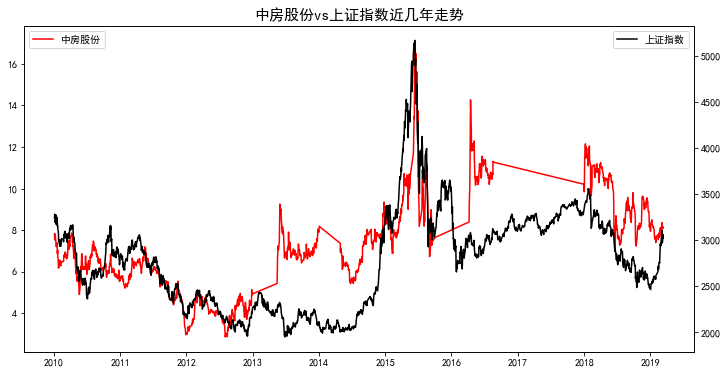

In [17]:
get_data_plot('600890','2010-01-01','中房股份')

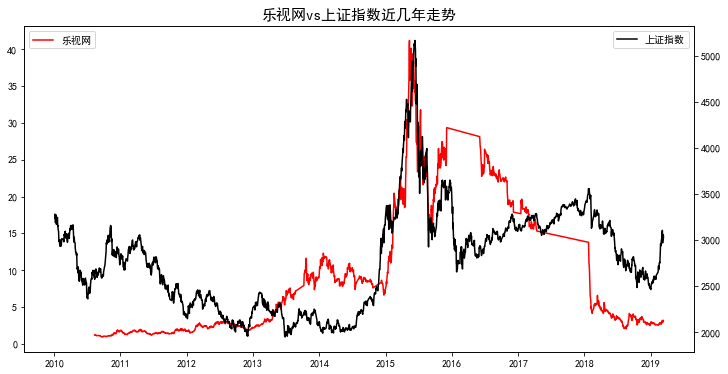

In [18]:
get_data_plot('300104','2010-01-01','乐视网')
#这里的价格是前复权了
#把时间拉长，乐视网从2010年上市到2015年大牛市，五年时间翻了N倍，创造了创业板的神话，但是2018年又响起了周杰伦熟悉的歌声“又回到过去...”

#### 利润同比

In [19]:
data.sort_values('利润同比',ascending=False)[:10]

,简称,流通股,市盈率,市净率,每股收益,每股公积,收入同比,利润同比,毛利率,净利率,收盘价,总市值,流通市值,成交量,换手率
code,,,,,,,,,,,,,,,
600425,青松建化,13.79,11.02,1.48,0.328,2.32,24.26,18509.93,30.60,23.16,4.82,66.457682,66.457682,97825791.0,7.09505
000616,海航投资,14.30,11.45,1.16,0.229,0.14,23.10,7225.10,22.08,178.33,3.50,50.058205,50.057505,35701063.0,2.49620
002272,川润股份,3.21,22.25,1.82,0.176,1.54,-13.51,7123.57,16.01,19.56,5.21,22.423840,16.705573,20224370.0,6.30741
601226,华电重工,11.55,86.22,1.52,0.041,1.06,27.25,5967.29,10.21,1.10,4.67,53.938500,53.938500,14948301.0,1.29423
600408,*ST安泰,10.07,5.40,3.29,0.566,1.44,48.98,5918.53,11.73,8.93,4.07,40.976760,40.976760,26774518.0,2.65937
600408,*ST安泰,10.07,5.40,3.29,0.566,1.44,48.98,5918.53,11.73,8.93,4.07,40.976760,40.976760,26774518.0,2.65937
600678,四川金顶,3.49,60.21,37.83,0.089,0.87,208.46,5475.05,17.72,9.10,7.14,24.917886,24.917886,21613902.0,6.19327
300523,辰安科技,1.03,78.04,6.61,0.560,2.67,97.93,4921.74,59.78,16.14,55.75,84.183573,57.180656,2493885.0,2.43149
002488,金固股份,7.69,72.73,3.08,0.125,3.32,7.92,4309.46,18.51,5.65,12.13,122.659004,93.256451,101961674.0,13.26230


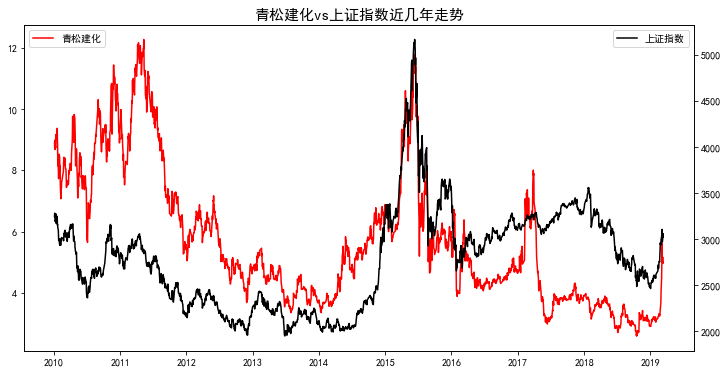

In [20]:
get_data_plot('600425','2010-01-01','青松建化')
#青松建化今年各项财务指标表现不错，但是近两年走势都不如大盘。

In [21]:
data.sort_values('利润同比',ascending=True)[:10]

,简称,流通股,市盈率,市净率,每股收益,每股公积,收入同比,利润同比,毛利率,净利率,收盘价,总市值,流通市值,成交量,换手率
code,,,,,,,,,,,,,,,
300163,先锋新材,3.30,0.0,3.66,-0.315,0.20,-17.18,-6472.94,41.65,-35.08,4.15,19.671000,13.677076,7514414.0,2.28008
300090,盛运环保,11.42,0.0,1.14,-0.159,1.66,-52.62,-5737.62,28.11,-35.91,2.64,34.846757,30.150808,86319327.0,7.55811
600238,*ST椰岛,4.45,0.0,7.01,-0.363,0.28,-49.56,-4843.68,25.43,-46.84,9.31,41.727420,41.429647,4797810.0,1.07816
600238,*ST椰岛,4.45,0.0,7.01,-0.363,0.28,-49.56,-4843.68,25.43,-46.84,9.31,41.727420,41.429647,4797810.0,1.07816
002164,宁波东力,4.40,0.0,5.97,-4.564,3.36,112.69,-4796.91,2.45,-26.92,4.30,30.071933,18.917567,34902618.0,7.93343
000806,银河生物,6.98,0.0,3.70,-0.106,0.99,-28.47,-4687.60,23.45,-20.10,6.69,73.584097,46.726191,129380343.0,18.52397
600501,航天晨光,4.21,0.0,1.68,-0.156,3.50,2.06,-4652.23,24.04,-3.73,8.55,36.019748,36.019748,18105521.0,4.29770
600302,标准股份,3.46,0.0,1.78,-0.097,1.00,-1.31,-3933.05,20.39,-6.43,6.05,20.933593,20.933593,5697585.0,1.64665
600610,*ST毅达,3.76,0.0,300.10,-0.020,0.36,0.00,-3843.40,0.00,0.00,3.73,39.958543,14.008932,9753798.0,2.59703


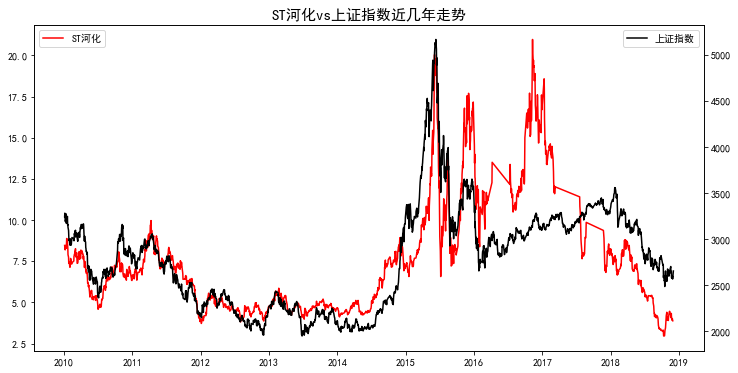

In [144]:
get_data_plot('000953','2010-01-01','ST河化')
#ST河化在股市低迷的时候反而表现比青松建化好
#各项财务指标一塌糊涂

#### 每股收益

In [22]:
#每股收益最高的十家股票
data.sort_values('每股收益',ascending=False)[:10]

,简称,流通股,市盈率,市净率,每股收益,每股公积,收入同比,利润同比,毛利率,净利率,收盘价,总市值,流通市值,成交量,换手率
code,,,,,,,,,,,,,,,
600519,贵州茅台,12.56,28.72,9.25,19.689,1.09,23.06,23.77,91.12,47.34,754.00,9471.731412,9471.731412,4056136.0,0.32289
603444,吉比特,0.41,20.52,5.17,7.090,14.84,8.90,14.30,91.46,43.70,192.97,138.711130,79.596671,1917511.0,4.64871
000661,长春高新,1.70,45.96,8.74,5.917,11.56,31.03,52.05,85.10,18.73,271.92,462.569271,462.285335,3846265.0,2.26240
601155,新城控股,22.46,8.27,2.84,4.690,1.17,33.58,74.02,36.69,19.38,38.44,867.484777,863.356321,19108819.0,0.85080
002304,洋河股份,12.44,17.78,5.12,4.671,0.49,24.22,26.11,73.03,33.57,110.71,1668.386415,1377.289765,6119310.0,0.49189
601318,中国平安,108.33,12.35,2.48,4.450,7.17,13.19,19.72,0.00,10.58,71.54,13077.684705,7749.688182,140546408.0,1.29743
300751,迈为股份,0.13,50.26,7.53,4.260,13.67,65.55,30.58,39.55,21.70,165.22,85.914400,21.478600,686942.0,5.28417
600585,海螺水泥,40.00,6.81,1.82,3.909,2.00,55.46,111.20,41.39,26.63,35.50,1881.252416,1419.894416,23062668.0,0.57661
300618,寒锐钴业,1.14,16.47,8.61,3.653,1.88,126.54,124.94,53.74,32.48,80.20,153.984000,91.415168,8758828.0,7.68426


In [146]:
p=data.sort_values('每股收益',ascending=False)['收盘价'][:10].mean()
pe=data.sort_values('每股收益',ascending=False)['市盈率'][:10].mean()
print(f'每股收益最高的十只股票平均价格为{p}元，平均市盈率为{pe}')

每股收益最高的十只股票平均价格为146.074元，平均市盈率为17.726000000000003


可见市场其实还是相对理性的，经营业绩好的公司总会被人挖掘出来，给予合理的估值。

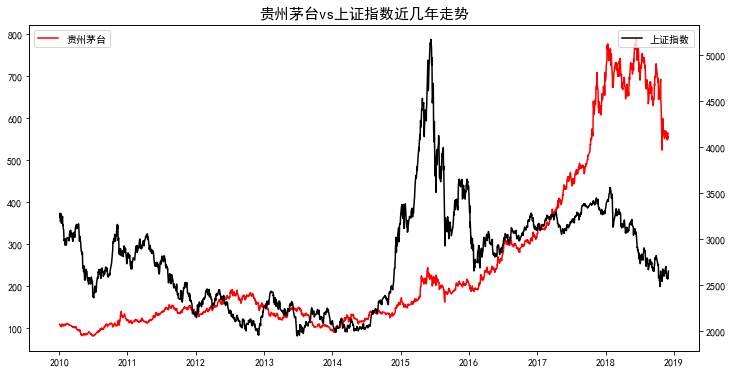

In [147]:
#贵州茅台近八年的股价走势
get_data_plot('600519','2010-01-01','贵州茅台')
#茅台才叫真牛吧，2015年鸡犬升天的时候，它却稳如泰山，
#2016年后伴随着股灾收割机的开启，大量股票腰斩，它却不断创新高。
#这走势一看还以为是美股标普走势呢

In [148]:
#每股收益最低的十只股票
data.sort_values('每股收益',ascending=True)[:10]

,简称,流通股,市盈率,市净率,每股收益,每股公积,收入同比,利润同比,毛利率,净利率,收盘价,总市值,流通市值,成交量,换手率
code,,,,,,,,,,,,,,,
002164,宁波东力,4.40,0.0,11.61,-4.564,3.36,112.69,-4796.91,2.45,-26.92,3.07,21.469962,13.506263,11397504.0,2.59068
600961,株冶集团,5.27,0.0,-2.93,-2.979,1.64,-11.22,-3749.51,-2.61,-17.52,7.61,40.139547,40.139547,1134701.0,0.21513
000911,南宁糖业,3.24,0.0,2.70,-1.999,4.44,68.77,-546.43,1.83,-22.75,6.27,20.319875,20.319875,3854802.0,1.18946
300032,金龙机电,7.89,0.0,1.11,-1.935,3.97,-15.76,-605.94,9.68,-73.98,3.44,27.629035,27.153896,22306498.0,2.82591
000063,中兴通讯,34.34,0.0,3.96,-1.732,2.73,-23.26,-285.92,32.30,-12.35,21.44,898.908843,736.276259,234759423.0,6.83608
002188,*ST巴士,2.15,0.0,-2.25,-1.684,5.45,-78.68,-816.16,-73.34,-474.00,3.71,10.967781,7.967282,6384337.0,2.97289
300008,天海防务,6.02,0.0,2.30,-1.379,1.21,-10.79,-1023.96,0.19,-160.90,3.13,30.048507,18.855402,15189000.0,2.52138
002200,云投生态,1.32,0.0,5.45,-1.267,4.20,-41.45,-279.83,-7.07,-81.37,6.28,11.563545,8.265617,3115625.0,2.36717
300116,坚瑞沃能,12.94,0.0,3.54,-1.197,2.02,-58.88,-487.28,1.39,-82.23,1.78,43.298937,23.035389,119920469.0,9.26654


中兴通讯应该是这里面比较熟悉的名字了，不出意外，受中美“毛衣战”影响，2018年三季度财务数据全部变脸：收入同比-23.26%，利润同比-285.93%，净利率-12.35，每股收益-1.732，估计是中美贸易战最大的受害者之一了。看看资本市场的反馈如何？

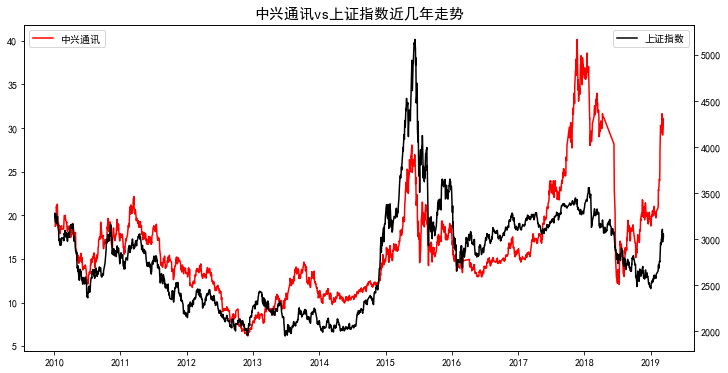

In [23]:
#中兴通讯走势
get_data_plot('000063','2010-01-01','中兴通讯')

在深圳的时候，经常会听到华为中兴，像金庸天龙八部里面经常被提到的北乔峰南慕容，当然，乔峰可一直没把南慕容放在眼里。中兴通讯2015年牛市的时候平平无奇，2017年因为5G概念，飞了一把，谁知2018年中美“毛衣战”飞来横祸，股价被拦腰一斩，甚是惨淡（其实还好，也就回到2017年之前）。中美“毛衣战”算是黑天鹅事件了，至少2018年年初的时候很少有人预料到会演变到这一步田地，后面解读的基本上都是马后炮。万物互联的时代一直在酝酿着，相信5G概念未来仍然会持续发酵，但是中兴仍然感觉力不从心，毕竟脖子被人掐住了，未来能否借助5G的发展突破困局，拭目以待。

#### 市值

In [150]:
#总市值最大的十只股票
data.sort_values('总市值',ascending=False)[:10]

,简称,流通股,市盈率,市净率,每股收益,每股公积,收入同比,利润同比,毛利率,净利率,收盘价,总市值,流通市值,成交量,换手率
code,,,,,,,,,,,,,,,
601398,工商银行,2696.12,6.03,0.88,0.672,0.43,7.71,5.10,0.00,41.53,5.41,19281.578509,14586.020698,222347405.0,0.08247
601939,建设银行,95.94,5.93,0.91,0.856,0.54,5.94,6.39,0.00,42.82,6.77,16925.743176,649.490620,144647923.0,1.50775
601857,中国石油,1619.22,22.05,1.16,0.263,0.70,17.30,177.16,22.40,2.81,7.73,14147.521585,12516.576615,80155247.0,0.04950
601288,农业银行,2940.55,5.54,0.82,0.510,0.50,12.01,7.25,0.00,37.51,3.62,12669.385826,10644.801639,304720205.0,0.10363
601318,中国平安,108.33,11.22,2.25,4.450,7.17,13.19,19.72,0.00,10.58,64.99,11880.328892,7040.148657,112194302.0,1.03570
601988,中国银行,2107.66,5.26,0.73,0.500,0.48,3.32,5.34,0.00,40.75,3.65,10745.154380,7692.941292,119871047.0,0.05687
600519,贵州茅台,12.56,22.90,7.38,19.689,1.09,23.06,23.77,91.12,47.34,601.20,7552.261174,7552.261174,8341468.0,0.66403
600036,招商银行,206.29,8.27,1.51,2.660,2.68,13.59,14.58,0.00,35.80,29.46,7429.766514,6077.287029,69025556.0,0.33461
600028,中国石化,955.58,9.17,1.02,0.495,0.99,18.80,56.31,18.15,2.89,6.06,7336.915305,5790.800925,160643995.0,0.16811


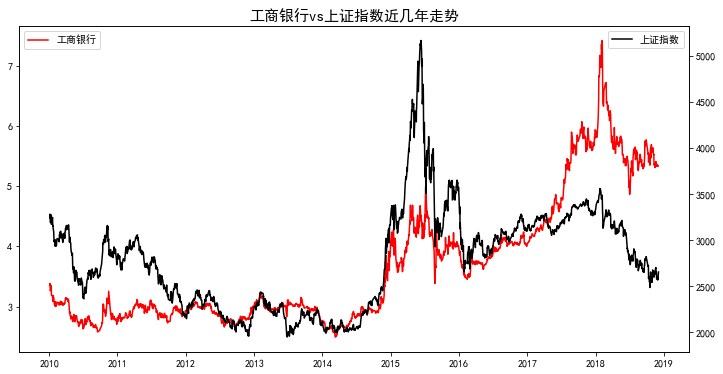

In [151]:
#工商银行走势
get_data_plot('601398','2010-01-01','工商银行')

其实从2017年以来，宇宙第一大行走势一直比大盘好很多，整个市场低迷的时候，银行股反而成了护盘的重要推手，当然大金融概念也是炒了一波。

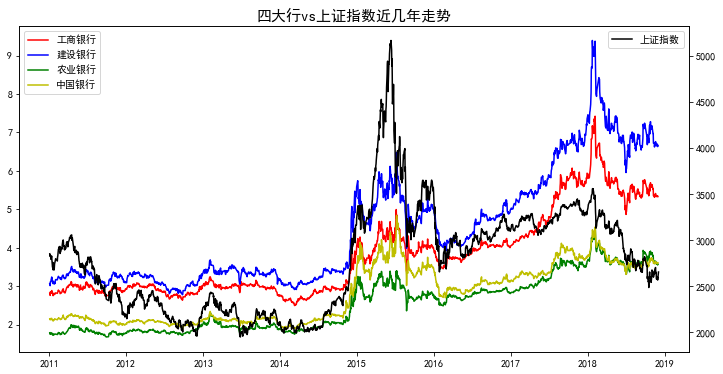

In [152]:
def get_data(code,startdate):
    df=ts.get_k_data(code,start=startdate)
    df.index=pd.to_datetime(df.date)
    return df.close
df=pd.DataFrame()
df['sh']=get_data('sh','2011-01-01')
codes={'601398':'工商银行','601939':'建设银行','601288':'农业银行','601988':'中国银行'}
for code,name in codes.items():
    df[name]=get_data(code,'2011-01-01')
fig = plt.figure(figsize=(12,6))  
ax1 = fig.add_subplot(111)  
ax1.plot(df['工商银行'],color='r',label='工商银行')
ax1.plot(df['建设银行'],color='b',label='建设银行')
ax1.plot(df['农业银行'],color='g',label='农业银行')
ax1.plot(df['中国银行'],color='y',label='中国银行')
ax1.legend(loc=2)
ax2=ax1.twinx()
ax2.plot(df['sh'],color='k',label='上证指数')
plt.title('四大行'+'vs上证指数近几年走势',fontsize=15)
ax2.legend(loc=1)
plt.show()

四大行走势还是很相似的，毕竟业务结构和盈利模式差异不明显，其中建行由于盘子小，波动性可能更强些，流通股本只有96亿，而工商银行、农业银行和中国银行分别为2696亿、2940亿和2107亿流通股本。

In [153]:
def get_data(code,startdate):
    df=ts.get_k_data(code,start=startdate)
    df.index=pd.to_datetime(df.date)
    return df.close
df=pd.DataFrame()
df['上证指数']=get_data('sh','2011-01-01')
codes={'601398':'工商银行','601939':'建设银行','601288':'农业银行','601988':'中国银行'}
for code,name in codes.items():
    df[name]=get_data(code,'2010-01-01')
def logreturn(data):
    logret=pd.DataFrame()
    for code in data.columns:
        logret[code]=np.log(data[code]/data[code].shift(1))
        logret.index=data.index
    return logret[1:]
df=pd.DataFrame()
df['上证指数']=get_data('sh','2011-01-01')
codes={'601398':'工商银行','601939':'建设银行','601288':'农业银行','601988':'中国银行'}
for code,name in codes.items():
    df[name]=get_data(code,'2010-01-01')
logret=logreturn(df)
logret.head()

,上证指数,工商银行,建设银行,农业银行,中国银行
date,,,,,
2011-01-05,-0.004941,-0.011809,-0.002287,-0.015233,-0.009350
2011-01-06,-0.005082,-0.007225,-0.015162,-0.007418,-0.002822
2011-01-07,0.005156,0.033164,0.032350,0.014781,0.015424
2011-01-10,-0.016691,-0.014130,0.008325,-0.007363,-0.012602
2011-01-11,0.004375,0.004614,0.014562,0.000000,0.006088


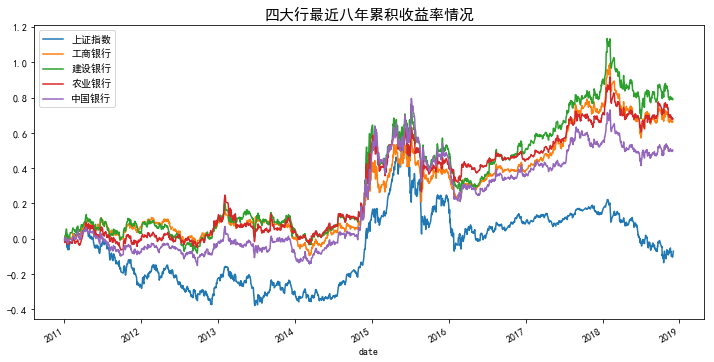

In [154]:
logret.cumsum().plot(figsize=(12,6))
plt.title('四大行最近八年累积收益率情况',fontsize=15)
plt.show()

In [155]:
def sum_return(r_sum):
    maxv=(r_sum.max()*100).round(2)
    minv=(r_sum.min()*100).round(2)
    meanv=(r_sum.mean()*100).round(2)
    stdv=(r_sum.std()*100).round(2)
    for i in range(len(r_sum.columns)):
        print(f'{r_sum.columns[i]}最高收益率为{maxv[i]}%,最低收益率{minv[i]}%,平均收益率{meanv[i]}%,标准差{stdv[i]}%')

In [156]:
r_sum=logret.cumsum()
sum_return(r_sum)

上证指数最高收益率为59.39%,最低收益率-38.04%,平均收益率-4.58%,标准差20.39%
工商银行最高收益率为99.33%,最低收益率-9.67%,平均收益率28.28%,标准差26.29%
建设银行最高收益率为113.61%,最低收益率-8.31%,平均收益率34.38%,标准差30.9%
农业银行最高收益率为91.72%,最低收益率-6.49%,平均收益率29.85%,标准差27.24%
中国银行最高收益率为79.53%,最低收益率-15.33%,平均收益率21.47%,标准差26.17%


假设从2011年1月1日（若无交易日顺延）开始买入四大行，持有到今天。区间最高收益率：建行为113.61%，工行为99.33%，农行91.72%，中行为79.53%，而上证指数为59.39%；最低收益率：建行为-8.31%，工行为-9..67%，农行-6.49%，中行为-15.33%，而上证指数为-38.04%.从标准差来看，建行波动最大。可以使用夏普率来比较，此处不展开分析。

In [24]:
#总市值最小的十只股票
data.sort_values('总市值',ascending=True)[:10]

,简称,流通股,市盈率,市净率,每股收益,每股公积,收入同比,利润同比,毛利率,净利率,收盘价,总市值,流通市值,成交量,换手率
code,,,,,,,,,,,,,,,
300028,金亚科技,3.44,5.52,1.26,0.105,1.06,-15.19,219.64,-10.68,287.64,0.77,2.648646,2.648608,0.0,0.00000
000995,*ST皇台,1.77,0.00,-4.16,-0.236,1.73,-76.61,37.82,-49.40,-440.96,4.33,7.681766,7.681656,4762173.0,2.68434
002260,*ST德奥,2.65,0.00,-3.83,-0.241,0.02,-5.85,-54.04,18.22,-11.80,3.23,8.565960,8.565960,12695211.0,4.78703
002323,*ST百特,3.16,218.46,2.11,0.004,0.12,-68.23,-98.14,23.81,1.09,1.31,9.769058,4.139926,0.0,0.00000
002604,*ST龙力,5.08,0.00,-1.82,-0.423,3.21,-37.50,-317.98,20.69,-37.52,1.87,11.211798,9.501010,15256163.0,3.00274
002188,*ST巴士,2.21,0.00,-1.83,-2.168,5.45,-75.58,68.48,-52.90,-444.36,3.91,11.559036,8.621794,5139700.0,2.33086
300029,天龙光电,2.00,0.00,11.03,-0.150,4.17,-93.03,-119.79,10.49,-337.45,5.79,11.580000,11.580000,6511771.0,3.25589
600462,ST九有,5.34,0.00,4.25,-0.023,1.20,318.99,-328.25,2.73,-0.56,2.30,12.276940,12.276940,29799086.0,5.58265
600462,ST九有,5.34,0.00,4.25,-0.023,1.20,318.99,-328.25,2.73,-0.56,2.30,12.276940,12.276940,29799086.0,5.58265


In [158]:
df=pd.DataFrame()
df['上证指数']=get_data('sh','2011-01-01')
codes={'300028':'金亚科技','002323':'*ST百特','002260':'*ST德奥','300029':'天龙光电'}
for code,name in codes.items():
    df[name]=get_data(code,'2010-01-01')
logret=logreturn(df)
r_sum=logret.cumsum()
sum_return(r_sum)

上证指数最高收益率为59.39%,最低收益率-38.04%,平均收益率-4.58%,标准差20.39%
金亚科技最高收益率为156.95%,最低收益率-256.7%,平均收益率-19.74%,标准差57.1%
*ST百特最高收益率为94.0%,最低收益率-191.41%,平均收益率-10.21%,标准差37.39%
*ST德奥最高收益率为236.79%,最低收益率-84.87%,平均收益率45.59%,标准差80.5%
天龙光电最高收益率为17.17%,最低收益率-187.58%,平均收益率-100.79%,标准差43.49%


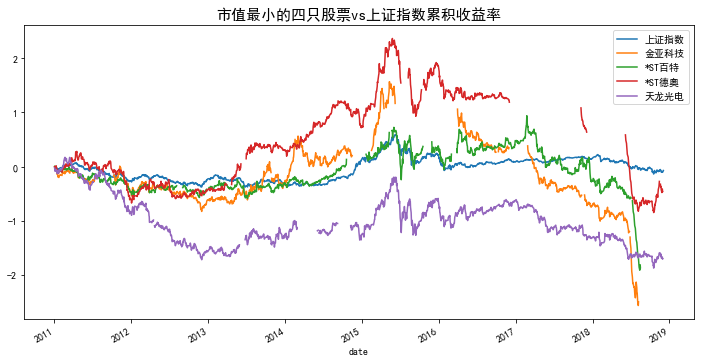

In [160]:
r_sum.plot(figsize=(12,6))
plt.title('市值最小的四只股票vs上证指数累积收益率',fontsize=15)
plt.show()

上证指数最高收益率为59.39%,最低收益率-38.04%,平均收益率-4.58%,标准差20.39%;  
金亚科技最高收益率为156.95%,最低收益率-256.7%,平均收益率-19.74%,标准差57.1%;  
\*ST百特最高收益率为94.0%,最低收益率-191.41%,平均收益率-10.21%,标准差37.39%;  
\*ST德奥最高收益率为236.79%,最低收益率-84.87%,平均收益率45.59%,标准差80.5%;  
天龙光电最高收益率为17.17%,最低收益率-187.58%,平均收益率-100.79%,标准差43.49%。  

不难发现，从区间累积收益率来看，除了天龙光电外，其余三只小市值股票最高收益率均高过上证指数，其中金亚科技和*ST德奥也高于四大行；但是，这三只股票的的区间累积收益率和标准差都明显大于四大行和上证指数。特别是把时间拉长来看，投资这只极小盘股很容易出现过山车，有种“辛辛苦苦奋斗十年，一夜之间回到解放前”的感觉。

### 选择股票组合
选股就是不断剔除股票，留下自己“中意”股票的过程。针对上述基本面和交易数据设置参数和过滤值，剔除掉大部分股票。注意，由于这里用到的基本面数据仅仅是2018年三季度的，企业的经营是动态演进的，市场交易频率更高，因而对股票的筛选也应该是一个动态的过程，这里只是给出一个静态的思路，以供参考，所选股票也不构成投资建议，切记！

In [25]:
#设置参数和过滤值(根据需要不断调整)
#市盈率>0
pe0=data['市盈率']>0
pe1=data['市盈率']<20
#市净率>0
pb0=data['市净率']>0
pb1=data['市净率']<2
#每股公积金>=1
res = data['每股公积'] >= 3
#流通股本<=20亿 
out = data['流通股'] <= 20
#每股收益>=1元 
eps = data['每股收益'] >= 1 
#总市值<500亿 
mktcap = data['总市值'] <= 500 
#收入同比正数
rev=data['收入同比']>15
#利润同比
profit=data['利润同比']>15
#净利率>5%
npr=data['净利率']>15
#取并集结果:

select = res & out & eps & mktcap & rev & pe0 &pe1 & pb0  & profit & npr
port= data[select] 
port

,简称,流通股,市盈率,市净率,每股收益,每股公积,收入同比,利润同比,毛利率,净利率,收盘价,总市值,流通市值,成交量,换手率
code,,,,,,,,,,,,,,,
002110,三钢闽光,9.91,3.80,1.43,3.169,3.59,20.25,59.62,27.76,19.31,16.04,262.155219,158.896579,25420137.0,2.56607
002159,三特索道,1.39,14.21,3.06,1.146,3.31,27.87,1032.43,56.14,31.54,21.70,30.090667,30.065200,3471804.0,2.50583
002233,塔牌集团,11.62,8.28,1.59,1.445,3.13,45.27,139.00,40.35,25.99,11.96,142.596092,138.981145,26226139.0,2.25689
002867,周大生,1.63,19.06,4.05,1.230,3.71,30.57,42.99,34.45,16.79,31.02,151.161391,50.586314,4085139.0,2.50505
600211,西藏药业,1.46,19.92,2.69,1.287,7.84,15.34,71.51,79.42,31.18,34.18,61.393844,49.762320,4393437.0,3.01770
600740,山西焦化,6.57,8.15,1.38,1.060,5.09,20.98,2376.51,10.54,24.74,9.23,139.931232,60.625664,27661902.0,4.21141
603035,常熟汽饰,1.72,9.11,1.53,1.114,4.06,16.22,89.96,22.25,30.01,13.54,37.912000,23.317834,3832255.0,2.22528
603086,先达股份,0.73,13.49,2.51,1.601,3.97,34.24,128.91,35.03,15.63,28.80,32.256000,20.883958,2139887.0,2.95101
603260,合盛硅业,2.61,12.30,5.00,3.353,3.39,71.51,132.50,42.15,26.61,55.01,368.567000,143.489077,2392959.0,0.91740
